# Review Text Attributes Models

## Import libraries and files

This notebook builds a range of machine learning models based upon the text characteristics within the review itself.

* Section 1 - Import libraries and dataset
* Section 2 - Pre-processing and feature engineering
* Section 3 - Models

Datasets needed to run the notebook:

* sampled_data.csv


# Section 1: Import libaries and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import string
import re
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest,chi2,RFECV,VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold,cross_val_score,learning_curve
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score, balanced_accuracy_score
from sklearn.metrics import auc,roc_auc_score,roc_curve,precision_recall_curve,plot_precision_recall_curve
from sklearn.metrics import precision_score,recall_score,f1_score,fbeta_score,f1_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Bring in already sampled data from the Review Post Attributes Models Notebook so the same sampled data is used for both sets
# of models
df = pd.read_csv("sampled_data.csv",index_col = 0)
df.head(2)

,Name,Category,Town,Type,Contributions,Title,Review,Rating,Date,LocCode,Cuisine,Score
0,Motte & Bailey,Food,Arundel,Café,21,Excellent Breakfasts,Whether it was the full English or poached egg...,5,2.0,0.0,Other,0
1,Carlton Hotel,Accommodation,Bognor,B&B/Inn,87,Won't be returning,Stayed here for one night for work. Check in a...,2,4.0,2.0,0,1


In [3]:
# Check shape
df.shape

(2602, 12)

# Section 2: Data Pre-processing and Feature Engineering

In [4]:
# Function to process the sampled text as per the Text Attributes Exploratory Data Analysis Notebook

def process(df):
    
    df['all_text'] = df['Title'] + ' ' + df['Review']
    df["num_words"] = df['all_text'].str.split().apply(len)
    df["num_chars"] = df['all_text'].apply(lambda x: len(x) - x.count(" "))
    df["av_word_len"] = df["num_chars"]/df["num_words"]
    df['uppercase'] = df["all_text"].apply(lambda x: sum(char.isupper() for char in x))
    df["prop_uc"] = df["uppercase"]/df["num_chars"]
    df['special_chars'] = df["all_text"].apply(lambda x: sum(char in string.punctuation for char in x))
    df["prop_sc"] = df["special_chars"]/df["num_chars"]
    df = df[["Category","Score","num_words","num_chars","av_word_len","prop_uc","prop_sc"]]
    
    return df

In [5]:
df.head(2)

,Name,Category,Town,Type,Contributions,Title,Review,Rating,Date,LocCode,Cuisine,Score
0,Motte & Bailey,Food,Arundel,Café,21,Excellent Breakfasts,Whether it was the full English or poached egg...,5,2.0,0.0,Other,0
1,Carlton Hotel,Accommodation,Bognor,B&B/Inn,87,Won't be returning,Stayed here for one night for work. Check in a...,2,4.0,2.0,0,1


In [6]:
df = process(df)
df.columns = ["Category","Score","WordCount","CharCount","WordLen","UpperCase","Punctuation"]
df.head(2)

,Category,Score,WordCount,CharCount,WordLen,UpperCase,Punctuation
0,Food,0,51,209,4.098039,0.028708,0.014354
1,Accommodation,1,152,657,4.322368,0.021309,0.031963


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2602 entries, 0 to 2601
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Category     2602 non-null   object 
 1   Score        2602 non-null   int64  
 2   WordCount    2602 non-null   int64  
 3   CharCount    2602 non-null   int64  
 4   WordLen      2602 non-null   float64
 5   UpperCase    2602 non-null   float64
 6   Punctuation  2602 non-null   float64
dtypes: float64(3), int64(3), object(1)
memory usage: 162.6+ KB


## Heatmap

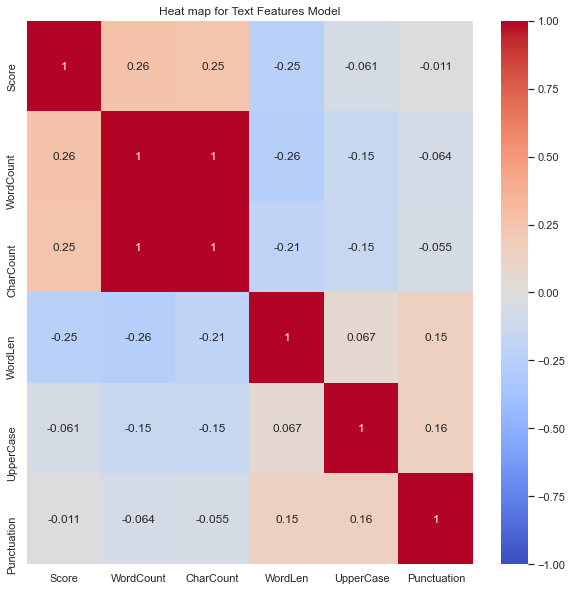

In [8]:
# Heatmap to show relationships
cor_mat = df.corr()
plt.figure(figsize=(10,10))
plt.title("Heat map for Text Features Model")
#plot heat map
g=sns.heatmap(cor_mat,annot=True,vmin=-1, cmap='coolwarm')

The number of words and characters have multicollinearity so one feature is dropped.

In [9]:
# Define X and y variables
X = df.drop(["Score","Category","CharCount"], axis = 1)
y = df["Score"]

## Train, test, split

In [10]:
# Function to split each balanced dataframe into training, validation and test splits with a stratified rating value
# It is noted that the train and test sets will not be exactly the same as for the Post Review Models due to the need to process
# each dataframe differently but is unlikely to make a large difference to the results.

def splitting(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X,y, stratify = y,test_size=0.2, random_state=42)
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test,stratify = y_test, test_size=0.50, random_state=42)     
    return X_train,y_train,X_val,y_val,X_test,y_test

In [11]:
# Run function
X_train,y_train,X_val,y_val,X_test,y_test = splitting(X,y)
print(X_train.shape,y_train.shape,X_val.shape,y_val.shape,X_test.shape,y_test.shape)

(2081, 4) (2081,) (261, 4) (261,) (260, 4) (260,)


In [12]:
# Values of Scores - check balanced
y_train.value_counts()

1    1041
0    1040
Name: Score, dtype: int64

In [13]:
# Check statistics to see if means and standard deviations vary so scaling is appropriate
X_train.describe()

,WordCount,WordLen,UpperCase,Punctuation
count,2081.000000,2081.000000,2081.000000,2081.000000
mean,107.183085,4.561029,0.028842,0.027557
std,96.558495,0.406269,0.019908,0.013357
min,17.000000,3.342105,0.000000,0.000000
25%,46.000000,4.289157,0.019444,0.019370
50%,77.000000,4.512195,0.025271,0.026022
75%,133.000000,4.765217,0.033981,0.033333
max,949.000000,6.750000,0.404396,0.179104


In [14]:
X_train.head()

,WordCount,WordLen,UpperCase,Punctuation
632,54,3.777778,0.019608,0.063725
510,122,4.663934,0.015817,0.021090
698,116,4.103448,0.052521,0.010504
2349,27,4.851852,0.015267,0.000000
2260,48,4.583333,0.027273,0.031818


## Scaling

In [15]:
# Scale data as the means and standard deviations vary across features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.fit_transform(X_val)

In [16]:
X_train_scaled

array([[0.03969957, 0.12784213, 0.04848679, 0.35580065],
       [0.11266094, 0.38787265, 0.03911324, 0.11775044],
       [0.10622318, 0.22340567, 0.12987532, 0.05864846],
       ...,
       [0.06437768, 0.4750539 , 0.02589347, 0.1315445 ],
       [0.00321888, 0.58918919, 0.11555262, 0.15654206],
       [0.16094421, 0.33186137, 0.0463448 , 0.13453815]])

## Feature Selection

In [17]:
# Recursive Feature Elimination using cross validation
def recurse(m,X,y):
    rfecv = RFECV(estimator = m, step = 1, scoring = "accuracy")
    rfecv.fit(X,y)
    rfecv.transform(X)
    return rfecv

In [18]:
result_lr = recurse(LogisticRegression(),X_train,y_train)
print(result_lr.n_features_)

4


In [19]:
print(result_lr.support_)
print(result_lr.grid_scores_)
print(result_lr.ranking_)

[ True  True  True  True]
[0.61174253 0.61030137 0.61078214 0.63672293]
[1 1 1 1]


In [20]:
X_train.columns

Index(['WordCount', 'WordLen', 'UpperCase', 'Punctuation'], dtype='object')

# Section 3: Training Models

In [21]:
# Function to train with specified model on the training set
def train_accuracy(model):
    kf = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3)
    scores = cross_val_score(model, X_train,y_train ,cv = kf, scoring = "accuracy", n_jobs =-1)
    return scores.mean()

In [22]:
print(X_train.shape,X_val.shape,y_train.shape,y_val.shape)

(2081, 4) (261, 4) (2081,) (261,)


## Dummy Classifer and Baseline ML Models

In [23]:
# Set models with defaut parameters
dummy_model = DummyClassifier(strategy = 'uniform')
nb = MultinomialNB()
lr = LogisticRegression()
rf = RandomForestClassifier()
svm = SVC(probability = True, kernel = 'rbf')

In [24]:
# Train models
dum_train = train_accuracy(dummy_model)
nb_train = train_accuracy(nb)
log_train = train_accuracy(lr)
rf_train = train_accuracy(rf)
svm_train = train_accuracy(svm)

In [25]:
train_summary = pd.DataFrame({"Dummy":[dum_train],"Naive Bayes":[nb_train],"LogReg":[log_train],"Random Forest": [rf_train],
                              "SVM":[svm_train]})
train_summary

,Dummy,Naive Bayes,LogReg,Random Forest,SVM
0,0.497529,0.634474,0.639116,0.632398,0.636864


All models outperform the dummy classifier

## Predicting with each Model

In [26]:
# Create function to run diagnostic reports and graphs

def run_mod(model,X,y):
    
    # Fit model on training set and predict on test set
    model_name = str(model)
    model.fit(X,y)
    y_pred = model.predict(X_val)
        
    # Classification Report
    print(classification_report(y_val, y_pred))
    
    # Learning Curve    
    train_sizes, train_scores, val_scores = learning_curve(model,X,y, scoring = "accuracy",
                                                            n_jobs =-1,train_sizes = np.linspace(0.01,1.0,50))
    train_mean = np.mean(train_scores, axis = 1)
    train_std = np.std(train_scores, axis = 1)
    val_mean = np.mean(val_scores, axis = 1)
    val_std = np.mean(val_scores, axis = 1)
    
    plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
    plt.plot(train_sizes, val_mean, color="#111111", label="Cross-validation score")
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color="#DDDDDD")

    plt.title("Learning Curve")
    plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
    plt.tight_layout()
    plt.show()
    
    # ROC Curve and AUC score
    target_probs = model.predict_proba(X_val)[:,1]
    false_positive_rate, true_positive_rate, threshold = roc_curve(y_val, target_probs)
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate)
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    # Precision-Recall Curve 
    precision, recall, thresholds = precision_recall_curve(y_val,target_probs)
    no_skill = len(y_val[y_val==1]) / len(y_val)
    plt.plot(recall, precision, marker='.')
    plt.plot([0, 1], [no_skill,no_skill], linestyle='--', label='No Skill Model')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()
    
    # histogram of predicted probabilities of the positive
    plt.hist(target_probs)
    plt.xlim(0,1)
    plt.title('Histogram of predicted probabilities')
    plt.xlabel('Predicted probability of Bad Review')
    plt.ylabel('Frequency')
       
    # Metrics
    accuracy = accuracy_score(y_val, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_val,y_pred)
    rocauc = roc_auc_score(y_val,target_probs)
    auc_score = auc(recall,precision)
    precision = precision_score(y_val, y_pred, average='binary')
    recall = recall_score(y_val, y_pred, average='binary')
    f1 = f1_score(y_val, y_pred, average='binary')
    f2_score = fbeta_score(y_val, y_pred, beta =2.0, labels=None, pos_label=1)
       
    
    run_mod.results = pd.DataFrame({"Accuracy":accuracy, "Balanced_acc":balanced_accuracy,
                                    "Precision":precision, "Recall":recall,
                                    "F1":f1,"F2":f2_score,"ROCAUC":rocauc,"PRAUC":auc_score}, index = [0]
                                  )
 
     
    # y_pred is an array of predictions
    best_thresh = None
    best_score = 0
    for thresh in np.arange(0.1, 0.501, 0.01):
        score = f1_score(y_val, y_pred>thresh)
        if score > best_score:
            best_thresh = thresh
            best_score = score
    print("Best F1 score:",best_score , "Best threshold value:",best_thresh)
                
    # Confusion Matrix
    fig, ax = plt.subplots()
    cf_matrix = confusion_matrix(y_val, y_pred)
    sns.heatmap(cf_matrix, annot = True, fmt = "d",)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title("Confusion Matrix", fontsize = 15)
    _ = ax.xaxis.set_ticklabels(['Good Reviews','Bad Reviews'],fontsize = 8)
    _ = ax.yaxis.set_ticklabels(['Good Reviews', 'Bad Reviews'], fontsize = 8)
    

              precision    recall  f1-score   support

           0       0.65      0.82      0.73       131
           1       0.76      0.56      0.65       130

    accuracy                           0.69       261
   macro avg       0.71      0.69      0.69       261
weighted avg       0.71      0.69      0.69       261



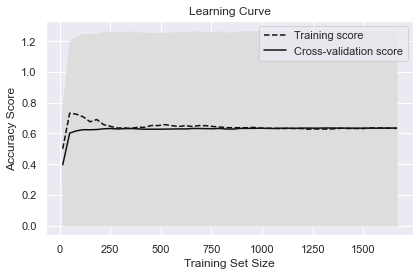

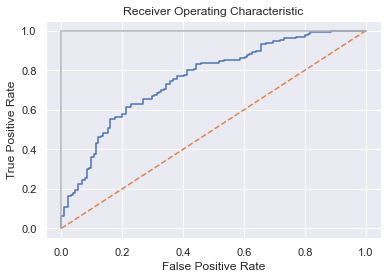

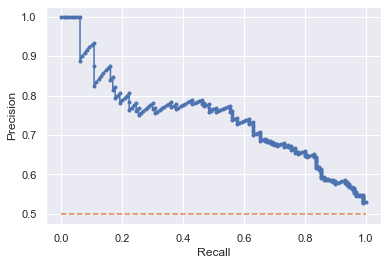

Best F1 score: 0.6460176991150441 Best threshold value: 0.1


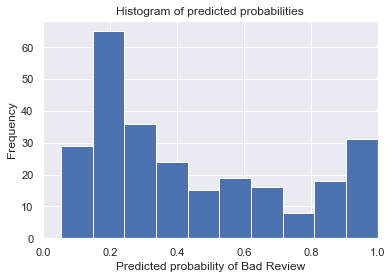

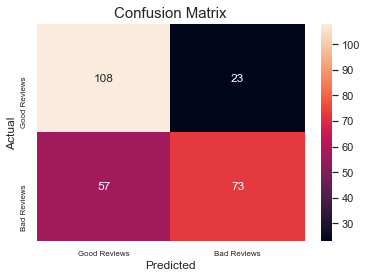

In [27]:
run_mod(nb,X_train,y_train)

In [28]:
nb_base = run_mod.results
nb_base

,Accuracy,Balanced_acc,Precision,Recall,F1,F2,ROCAUC,PRAUC
0,0.693487,0.692983,0.760417,0.561538,0.646018,0.592532,0.757017,0.743251


              precision    recall  f1-score   support

           0       0.68      0.72      0.70       131
           1       0.70      0.65      0.67       130

    accuracy                           0.69       261
   macro avg       0.69      0.69      0.69       261
weighted avg       0.69      0.69      0.69       261



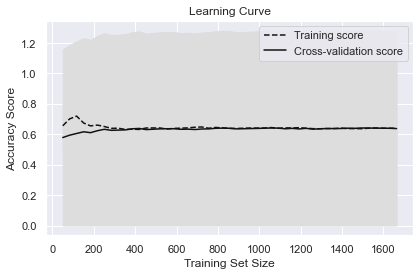

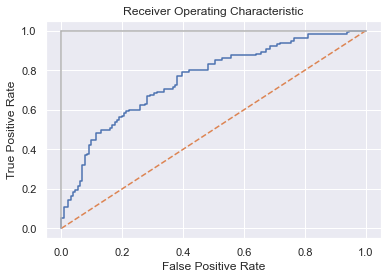

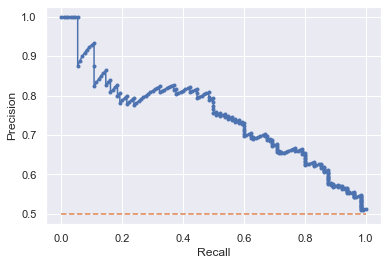

Best F1 score: 0.6746031746031745 Best threshold value: 0.1


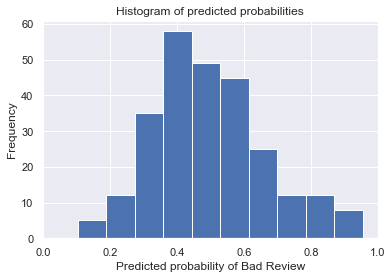

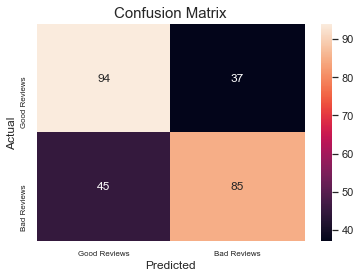

In [29]:
run_mod(lr,X_train,y_train)

In [30]:
lr_base = run_mod.results
lr_base

,Accuracy,Balanced_acc,Precision,Recall,F1,F2,ROCAUC,PRAUC
0,0.685824,0.685702,0.696721,0.653846,0.674603,0.661994,0.754081,0.746447


              precision    recall  f1-score   support

           0       0.62      0.65      0.64       131
           1       0.63      0.61      0.62       130

    accuracy                           0.63       261
   macro avg       0.63      0.63      0.63       261
weighted avg       0.63      0.63      0.63       261



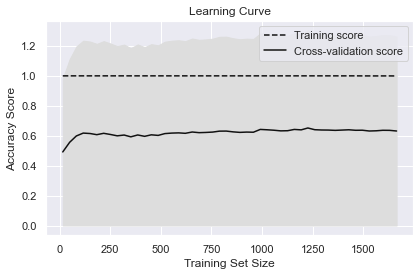

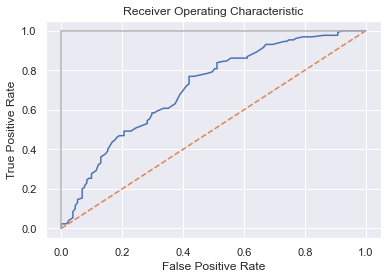

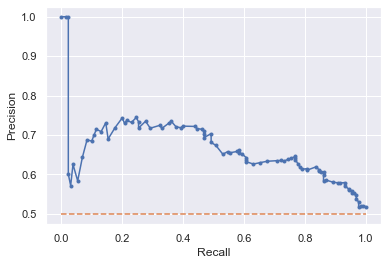

Best F1 score: 0.6196078431372549 Best threshold value: 0.1


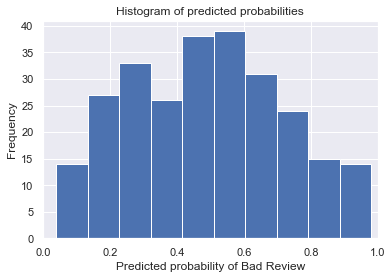

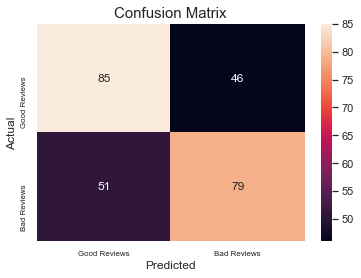

In [31]:
run_mod(rf,X_train,y_train)

In [32]:
rf_base = run_mod.results
rf_base

,Accuracy,Balanced_acc,Precision,Recall,F1,F2,ROCAUC,PRAUC
0,0.628352,0.628274,0.632,0.607692,0.619608,0.612403,0.708691,0.667239


              precision    recall  f1-score   support

           0       0.67      0.79      0.72       131
           1       0.74      0.60      0.66       130

    accuracy                           0.70       261
   macro avg       0.70      0.70      0.69       261
weighted avg       0.70      0.70      0.69       261



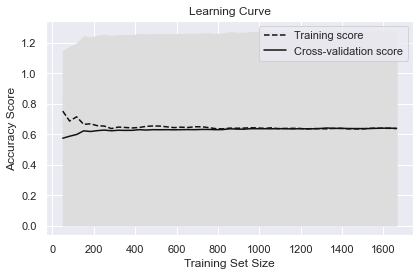

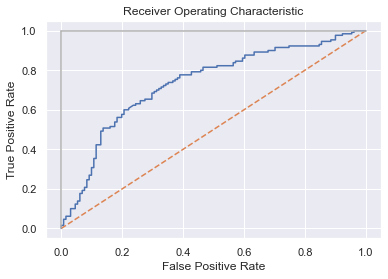

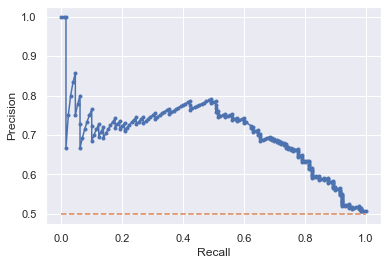

Best F1 score: 0.6638297872340425 Best threshold value: 0.1


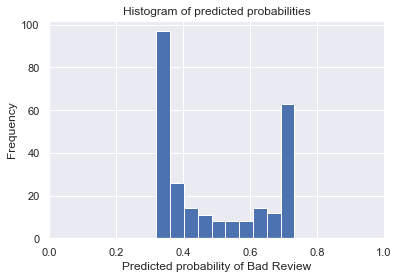

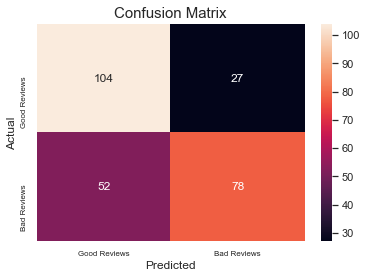

In [33]:
run_mod(svm,X_train,y_train)

In [34]:
svm_base = run_mod.results
svm_base

,Accuracy,Balanced_acc,Precision,Recall,F1,F2,ROCAUC,PRAUC
0,0.697318,0.696947,0.742857,0.6,0.66383,0.624,0.733412,0.701837


In [35]:
models = ["Multinomial NB","Logistic Regression","Random Forest","Support Vector"]

training_summary = pd.concat([nb_base,lr_base,rf_base,svm_base])
training_summary.set_index([models],inplace = True)
training_summary.drop(columns = ["Balanced_acc","F2","PRAUC"])

,Accuracy,Precision,Recall,F1,ROCAUC
Multinomial NB,0.693487,0.760417,0.561538,0.646018,0.757017
Logistic Regression,0.685824,0.696721,0.653846,0.674603,0.754081
Random Forest,0.628352,0.632000,0.607692,0.619608,0.708691
Support Vector,0.697318,0.742857,0.600000,0.663830,0.733412


Analysis:

* The models perform similarly to the review post attributes models and are fairly poor
* The best AUROC score of approx 75% and recall of 70% indicates the models do not classify the data well